# Differentiation techniques:
Here I want to compare the different differention technqiues given by my own implementation and in pysindy.

In [65]:
from spectral_derivative import flattenandextendfunc_1d,calc_deriv_fftn,calc_deriv_fftn_with_ext
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
from test_data import add_noise

## Data

In [57]:
# Do the same for one dimensional function
n= 100# amount of points
L=3#2*np.pi#length of domain
dx = L/n
const=0#np.pi/2
a=1
b=1
x = np.linspace(-L/2+const, L/2+const, num=n)
f = np.cos(a*x+b)
dfdx = -a*np.sin(a*x+b)

## Derivatives

In [38]:
from pysindy.differentiation import SmoothedFiniteDifference, SpectralDerivative

In [39]:
dfdx_fd = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(f, dx)
dfdx_myfft =  calc_deriv_fftn_with_ext(f,[x],[0],[dx])
dfdx_fft =  SpectralDerivative()._differentiate(f, dx)
dfdx_sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})._differentiate(f, dx)

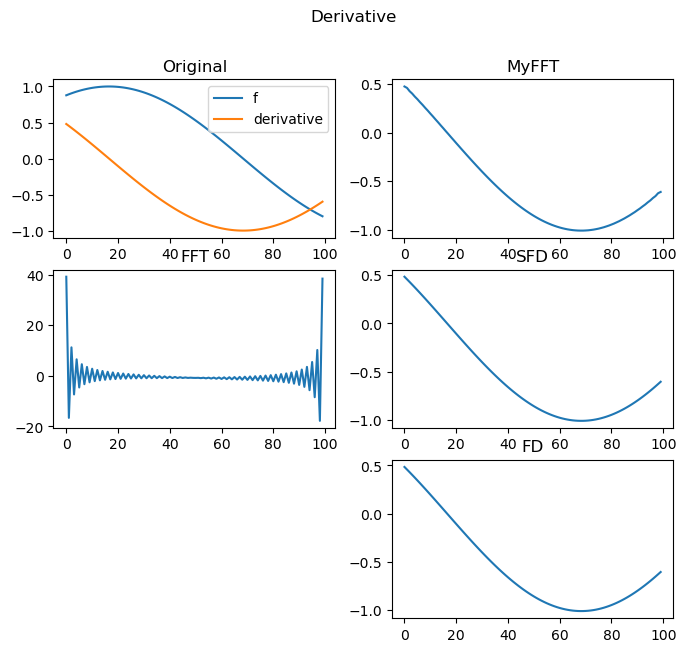

In [40]:
plt.figure(figsize=(8,7))
plt.suptitle("Derivative")
plt.subplot(3,2,1)
plt.title("Original")
plt.plot(f,label="f")
plt.plot(dfdx,label="derivative")
plt.legend()
plt.subplot(3,2,2)
plt.title("MyFFT")
plt.plot(dfdx_myfft,label="MyFFT")
plt.subplot(3,2,3)
plt.title("FFT")
plt.plot(dfdx_fft,label="FFT")
plt.subplot(3,2,4)
plt.title("SFD")
plt.plot(dfdx_sfd,label="SFD")
plt.subplot(3,2,6)
plt.title("FD")
plt.plot(dfdx_fd)

In [54]:
for x in zip([n], list(f.shape)):
    print(x)

(20, 100)


In [58]:
newf,newx,n= flattenandextendfunc_1d(f,x)
df =  SpectralDerivative()._differentiate(newf, dx)
start = [n]
end = [sum(o) for o in zip([n], list(f.shape))] #end = n0+u.shape[0],n1+u.shape[1],...
myslice =tuple(slice(*indexes) for indexes in zip(start, end))
dfdx_fft_ext = df[myslice]

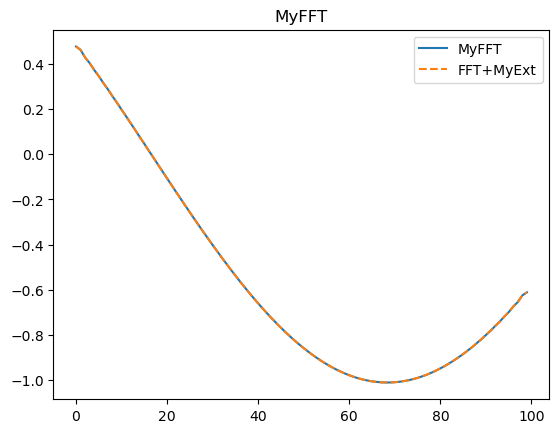

In [63]:
plt.title("MyFFT")
plt.plot(dfdx_myfft,label="MyFFT")
plt.plot(dfdx_fft_ext,'--',label="FFT+MyExt")
plt.legend()

## Derivatives with noise

Noise level: 0
Noise level: 1e-10
Noise level: 1e-09
Noise level: 1e-08
Noise level: 1e-07
Noise level: 1e-06
Noise level: 1e-05
Noise level: 0.0001
Noise level: 0.001
Noise level: 0.01


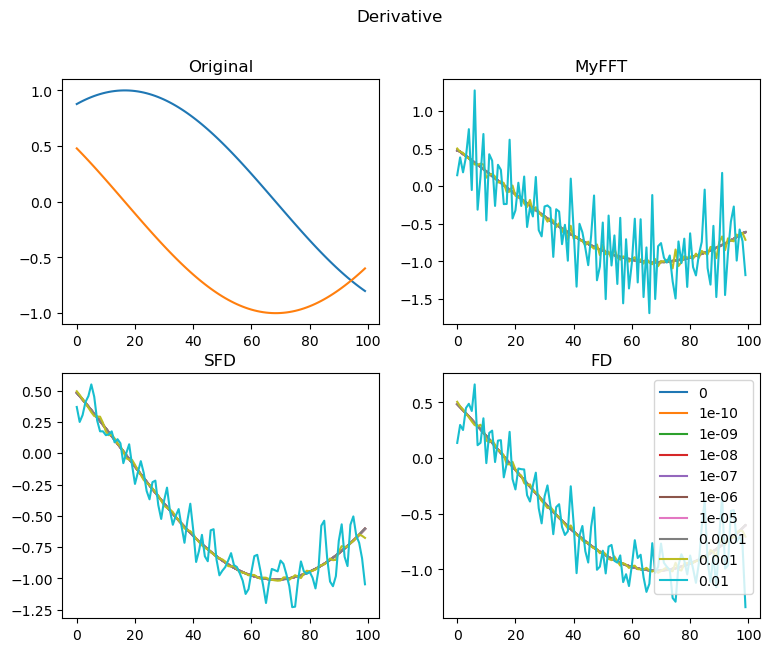

In [74]:
noise_levels = [0]+[10**(-10+i) for i in range(0,9)]
plt.figure(figsize=(9,7))
plt.suptitle("Derivative")
plt.subplot(2,2,1)
plt.title("Original")
plt.plot(f,label="f")
plt.plot(dfdx,label="derivative")
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    f_noise = add_noise(f,target_noise)
    dfdx_fd = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(f_noise, dx)
    dfdx_myfft =  calc_deriv_fftn_with_ext(f_noise,[x],[0],[dx])
    dfdx_fft =  SpectralDerivative()._differentiate(f_noise, dx)
    dfdx_sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})._differentiate(f_noise, dx)
    plt.subplot(2,2,2)
    plt.title("MyFFT")
    plt.plot(dfdx_myfft,label=str(target_noise))
    plt.subplot(2,2,3)
    plt.title("SFD")
    plt.plot(dfdx_sfd,label=str(target_noise))
    plt.subplot(2,2,4)
    plt.title("FD")
    plt.plot(dfdx_fd,label=str(target_noise))
plt.legend()

#plt.savefig("noise_levels")